## Imports

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import json
import matplotlib.pyplot as plt

In [2]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [3]:
%run ../iu_xray.py

In [23]:
REPORTS_DIR = os.path.join(DATASET_DIR, 'reports')

## Load data

In [29]:
reports_fname = os.path.join(reports_dir, 'reports.json')
with open(reports_fname, 'r') as f:
    reports_as_dict = json.load(f)
    reports = list(reports_as_dict.values())
len(reports_as_dict), len(reports)

(3955, 3955)

In [30]:
info_fname = os.path.join(DATASET_DIR, 'info.json')
with open(info_fname, 'r') as f:
    info = json.load(f)
len(info)

2

In [31]:
info

{'classification': {'CXR2323_IM-0895-2001.png': 'lateral-left',
  'CXR1946_IM-0615-1001.png': 'frontal',
  'CXR544_IM-2148-1002.png': 'lateral-left',
  'CXR1402_IM-0257-3001.png': 'lateral-left',
  'CXR573_IM-2171-12012.png': 'frontal',
  'CXR1947_IM-0616-1001.png': 'frontal',
  'CXR3136_IM-1475-1001.png': 'frontal',
  'CXR37_IM-1847-0001-0002.png': 'frontal',
  'CXR3979_IM-2038-2001.png': 'lateral-left',
  'CXR188_IM-0569-1002.png': 'lateral-left',
  'CXR1775_IM-0508-1001.png': 'frontal',
  'CXR518_IM-2131-2001.png': 'lateral-left',
  'CXR2202_IM-0811-1002.png': 'lateral-left',
  'CXR3541_IM-1733-0001-0002.png': 'frontal',
  'CXR2855_IM-1263-1001.png': 'frontal',
  'CXR3807_IM-1917-1001.png': 'frontal',
  'CXR531_IM-2140-2001.png': 'lateral-left',
  'CXR1279_IM-0185-1001.png': 'frontal',
  'CXR2780_IM-1218-1003.png': 'lateral-left',
  'CXR3225_IM-1525-2001.png': 'lateral-left',
  'CXR3533_IM-1726-2001.png': 'lateral-left',
  'CXR901_IM-2409-3001.png': 'frontal',
  'CXR3016_IM-1392-200

In [65]:
with open(info_fname, 'w') as f:
    json.dump(info, f)

In [34]:
info['marks']['rotated_left']

['CXR947_IM-2442-1001.png',
 'CXR994_IM-2478-1001.png',
 'CXR2146_IM-0766-13013.png']

### Rotate images

NOTE: are already rotated!!

In [55]:
rotations = [
    ('left', -90),
    ('right', 90),
    ('bottom', 180),
]

In [ ]:
for key, degrees in rotations:
    images_key = f'rotated_{key}'
    for image_name in info['marks'][images_key]:
        filepath = os.path.join(DATASET_DIR, 'images', image_name)
        img = Image.open(filepath).rotate(degrees)
        # img.save(filepath)

## Clean text

### Tokenize and clean

In [36]:
import re
from collections import defaultdict, Counter

In [37]:
# text = 'The previously<BR>described XXXX deformity'
text = """1. low lung volumes
2. exam limited on lateral view by superimposed soft tissue and bony structures of the arm
3. lungs appear grossly clear . no evidence of pneumonia .
4. heart and pulmonary xxxx appear normal
5. pleural spaces are clear
6. mediastinal contours appear normal
7. no acute cardiopulmonary disease on this exam
8."""
re.sub(r'< ?br ?\\?>', ' ', text.lower())

'1. low lung volumes\n2. exam limited on lateral view by superimposed soft tissue and bony structures of the arm\n3. lungs appear grossly clear . no evidence of pneumonia .\n4. heart and pulmonary xxxx appear normal\n5. pleural spaces are clear\n6. mediastinal contours appear normal\n7. no acute cardiopulmonary disease on this exam\n8.'

In [38]:
def remove_consecutive_dots(tokens):
    clean_tokens = []
    last_was_dot = False
    for token in tokens:
        is_dot = (token == '.')
        if last_was_dot and is_dot:
            continue

        clean_tokens.append(token)
        last_was_dot = is_dot
            
    return clean_tokens

In [39]:
remove_consecutive_dots(['.', '.', 'asdf', 'hello', '.', 'abc', '.', '.', 'c', '.'])

['.', 'asdf', 'hello', '.', 'abc', '.', 'c', '.']

In [40]:
NUMBER_TOKEN = 'NUMBER'

def text_to_tokens(text):
    text = text.lower()
    text = re.sub(r'(\[)?&amp;[gl]t;(\])?', ' ', text)
    
    text = re.sub(r'(;|,+)', r',', text)
    
    text = re.sub(r'\d+(\.|/)\d+', NUMBER_TOKEN, text)
    
    text = re.sub(r'< ?br ?\\?>', ' ', text)
    text = re.sub(r'[\[\]<>]', '', text)
    text = re.sub(r'(\(|\))', r' \1 ', text)
    
    text = re.sub(r'\.+', r'.', text)
    text = re.sub(r'([a-zA-Z])(\.|,|/)', r'\1 \2', text)
    text = re.sub(r'(\.|,|/)([a-zA-Z])', r'\1 \2', text)
    
    text = re.sub(r'\d+\.[^\d]', r' . ', text) # Enumerators, like "1. bla bla, 2. bla bla"
    text = re.sub(r'(\d)\.', r'\1 .', text)
    
    text = re.sub(r'([^\w])\d+(a|st|nd|th|rd|\%|mm|xxxx)?', f'\1 {NUMBER_TOKEN}', text)
    
    text = re.sub(r'NUMBER\.', 'NUMBER .', text)
    
    tokens = remove_consecutive_dots(text.split())
    if tokens[0] == '.':
        tokens = tokens[1:]
        
    if tokens[-1] != '.':
        tokens.append('.')
    return tokens

In [35]:
text_to_tokens(text)

NameError: name 'text' is not defined

In [41]:
IGNORE_TOKENS = set(['p.m.'])
token_appearances = Counter()
errors = defaultdict(list)

cleaned_reports_as_dict = dict()

for report in reports:
    filename = report['filename']
    findings = report['findings']
    impression = report['impression']

    n_images = len(report['images'])
    if n_images == 0:
        errors['no-images'].append(filename)
        continue
    
    text = findings
    if findings is None and impression is None:
        errors['text-none'].append(filename)
        continue
    elif findings is None:
        errors['findings-none'].append(filename)
        text = impression
    elif impression is None:
        errors['impression-none'].append(filename)

    # Clean and tokenize text
    tokens = [token for token in text_to_tokens(text) if token not in IGNORE_TOKENS]
    token_appearances += {
        token: 1
        for token in tokens
    }

    cleaned_report = {k: v for k, v in report.items()}
    cleaned_report['clean_text'] = ' '.join(tokens)

    cleaned_reports_as_dict[filename] = cleaned_report

print({k: len(v) for k, v in errors.items()})
print(len(token_appearances))
len(cleaned_reports_as_dict), len(reports)

{'findings-none': 489, 'impression-none': 6}
1878


(3826, 3826)

In [42]:
len([k for k, v in token_appearances.items() if v > 1])

1274

In [43]:
sorted([(k, v) for k, v in token_appearances.items() if re.search(r'(NUM|\d)', k)],
       key=lambda x:x[1], reverse=False)

[('t7,', 1),
 ('4', 1),
 ('t5', 1),
 ('l2', 1),
 ('t12-l1', 1),
 ('t8,', 1),
 ('l2-l', 1),
 ('l4', 1),
 ('s1', 1),
 ('13', 1),
 ('t6', 1),
 ('t4', 1),
 ('l3', 1),
 ('t12,', 1),
 ('l1-l', 1),
 ('t9-t10', 1),
 ('l1', 2),
 ('l1,', 2),
 ('t7', 2),
 ('t10', 3),
 ('t6,', 3),
 ('t11', 4),
 ('3', 4),
 ('NUMBER\x01', 4),
 ('t9', 5),
 ('t12', 6),
 ('2', 20),
 ('NUMBER', 201)]

### Review errors

In [197]:
reports_as_dict[errors['no-images'][0]]

IndexError: list index out of range

### Review specific tokens

In [289]:
found = []

for report in cleaned_reports_as_dict.values():
    name = report['filename']
    text = report['findings']
    
    clean = report.get('clean_text', None)
    if not clean:
        try:
            clean = cleaned_reports_as_dict[name]['clean_text']
        except:
            pass
    
    if clean is None:
        continue
        
    s = re.search(r' \d+ ', clean)
    if s:
        found.append((name, text, clean)) # s.group(0)

print(len(found))
found

0


[]

### Save cleaned reports

NOTE: Save after image info below

In [44]:
fname = os.path.join(REPORTS_DIR, 'reports.clean.v2.json')
with open(fname, 'w') as f:
    json.dump(cleaned_reports_as_dict, f)

## Add side to image info (in cleaned reports)

`side` can be one of (`frontal`, `lateral-left`, `lateral-right`)

In [44]:
fname = os.path.join(reports_dir, 'reports.clean.json')
with open(fname, 'r') as f:
    clean_reports = json.load(f)
len(clean_reports)

3826

In [45]:
wrong_images = set(info['marks']['wrong'])
broken_images = set(info['marks']['broken'])

In [46]:
for report_name, report_dict in clean_reports.items():
    new_images_info = []
    for image_info in report_dict['images']:
        image_name = image_info['id']
        image_name = f'{image_name}.png'

        image_info['side'] = info['classification'][image_name]
        image_info['wrong'] = image_name in wrong_images
        image_info['broken'] = image_name in broken_images

        new_images_info.append(image_info)
    
    report_dict['images'] = new_images_info
    clean_reports[report_name] = report_dict
    
len(clean_reports)

3826

In [47]:
fname = os.path.join(reports_dir, 'reports.clean.json')
with open(fname, 'w') as f:
    json.dump(clean_reports, f)

## Save common vocab

In [45]:
%run ../vocab/__init__.py
%run ../iu_xray.py

In [46]:
train_dataset = IUXRayDataset(dataset_type='train', recompute_vocab=True)
len(train_dataset)

5923

In [47]:
vocab = train_dataset.get_vocab()
len(vocab)

1741

In [48]:
prev_vocab = load_vocab('iu_xray')
len(prev_vocab), len(vocab)

(1741, 1741)

In [49]:
idx = 1000
a = [(k, v) for k, v in vocab.items() if v == idx][0]
b = [(k, v) for k, v in prev_vocab.items() if v == idx][0]
a, b

(('persistently', 1000), ('persistently', 1000))

In [50]:
save_vocab('iu_xray', vocab)

## Calculate image normalization

In [1]:
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [19]:
%run ../../utils/images.py

In [5]:
image_folder = os.path.join(DATASET_DIR, 'images')

In [10]:
dataset = IUXRayDataset('train')
len(dataset)

5923

In [14]:
train_images = [
    i if i.endswith('.png') else f'{i}.png'
    for i in [r['image_name'] for r in dataset.reports]
]
len(train_images)

5923

In [20]:
mean, std = compute_mean_std(ImageFolderIterator(image_folder, train_images), show=True)
mean, std

(tensor([0.4821, 0.4821, 0.4821]), tensor([0.2374, 0.2374, 0.2374]))

### Plot average image

In [ ]:
from torchvision import transforms

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [ ]:
summed = torch.zeros(3, 256, 256)

for image_name in tqdm(image_names):
    fpath = os.path.join(image_folder, image_name)
    image = transform(Image.open(fpath).convert('RGB'))
    summed += image
    
summed /= len(image_names)

In [11]:
average_image = summed.mean(dim=0)
average_image.size()

torch.Size([256, 256])

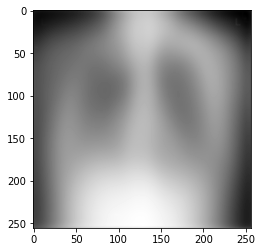

In [16]:
plt.imshow(average_image, cmap='gray')

## Test `IUXrayDataset` class

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms

In [5]:
%run ../iu_xray.py

In [6]:
dataset = IUXRayDataset(dataset_type='all', frontal_only=True)
len(dataset), len(dataset.word_to_idx)

(3800, 1775)

In [60]:
item = dataset[0]
image = item.image
labels = item.labels
report = item.report
image.size(), labels.size(), len(report)

(torch.Size([3, 512, 512]), torch.Size([14]), 4)

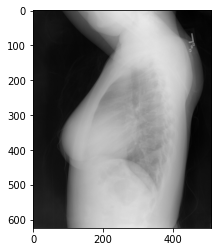

In [10]:
plt.imshow(image.numpy().transpose(1, 2, 0))

In [66]:
dataset.get_labels_presence_for('Cardiomegaly')

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 0),
 (8, 0),
 (9, 0),
 (10, 0),
 (11, 0),
 (12, 0),
 (13, 0),
 (14, 0),
 (15, 0),
 (16, 0),
 (17, 0),
 (18, 0),
 (19, 0),
 (20, 1),
 (21, 1),
 (22, 0),
 (23, 0),
 (24, 0),
 (25, 0),
 (26, 0),
 (27, 0),
 (28, 0),
 (29, 0),
 (30, 0),
 (31, 0),
 (32, 0),
 (33, 0),
 (34, 0),
 (35, 0),
 (36, 0),
 (37, 0),
 (38, 0),
 (39, 0),
 (40, 0),
 (41, 0),
 (42, 0),
 (43, 1),
 (44, 1),
 (45, 0),
 (46, 0),
 (47, 0),
 (48, 0),
 (49, 0),
 (50, 0),
 (51, 0),
 (52, 0),
 (53, 0),
 (54, 0),
 (55, 0),
 (56, 0),
 (57, 0),
 (58, 0),
 (59, 0),
 (60, 0),
 (61, 0),
 (62, 0),
 (63, 0),
 (64, 0),
 (65, 0),
 (66, 0),
 (67, 0),
 (68, 0),
 (69, 0),
 (70, 0),
 (71, 0),
 (72, 1),
 (73, 1),
 (74, 0),
 (75, 0),
 (76, 0),
 (77, 0),
 (78, 0),
 (79, 1),
 (80, 0),
 (81, 0),
 (82, 0),
 (83, 0),
 (84, 0),
 (85, 0),
 (86, 0),
 (87, 0),
 (88, 0),
 (89, 0),
 (90, 0),
 (91, 0),
 (92, 0),
 (93, 0),
 (94, 0),
 (95, 0),
 (96, 0),
 (97, 0),
 (98, 0),
 (99, 0),
 (100, 0),

### Review different image shapes

In [205]:
shapes = set()

for idx in range(len(dataset)):
    image, _ = dataset[idx]
    shapes.add(image.numpy().shape)

len(shapes)

251

In [206]:
shapes

{(3, 378, 512),
 (3, 391, 512),
 (3, 392, 512),
 (3, 399, 512),
 (3, 403, 512),
 (3, 409, 512),
 (3, 413, 512),
 (3, 415, 512),
 (3, 419, 512),
 (3, 420, 512),
 (3, 421, 512),
 (3, 422, 512),
 (3, 423, 512),
 (3, 424, 512),
 (3, 425, 512),
 (3, 426, 512),
 (3, 428, 512),
 (3, 429, 512),
 (3, 430, 512),
 (3, 431, 512),
 (3, 433, 512),
 (3, 434, 512),
 (3, 435, 512),
 (3, 436, 512),
 (3, 437, 512),
 (3, 441, 512),
 (3, 442, 512),
 (3, 443, 512),
 (3, 446, 512),
 (3, 447, 512),
 (3, 448, 512),
 (3, 449, 512),
 (3, 450, 512),
 (3, 451, 512),
 (3, 454, 512),
 (3, 456, 512),
 (3, 457, 512),
 (3, 459, 512),
 (3, 460, 512),
 (3, 461, 512),
 (3, 462, 512),
 (3, 463, 512),
 (3, 464, 512),
 (3, 466, 512),
 (3, 467, 512),
 (3, 468, 512),
 (3, 469, 512),
 (3, 470, 512),
 (3, 471, 512),
 (3, 472, 512),
 (3, 473, 512),
 (3, 474, 512),
 (3, 475, 512),
 (3, 476, 512),
 (3, 478, 512),
 (3, 479, 512),
 (3, 480, 512),
 (3, 481, 512),
 (3, 482, 512),
 (3, 483, 512),
 (3, 484, 512),
 (3, 485, 512),
 (3, 486

### Load single images

In [11]:
fname = DATASET_DIR + '/images/CXR5_IM-2117-1003002.png'
img = Image.open(fname)
img_tensor = transforms.ToTensor()(img)
img.size, img_tensor.size()

((512, 621), torch.Size([3, 621, 512]))

## Debug augmentation

In [40]:
%run ../iu_xray.py
%run ../tools/augmentation.py

In [41]:
dataset = IUXRayDataset(dataset_type='all', frontal_only=False)
len(dataset)

7426

In [43]:
aug = Augmentator(dataset, dont_shuffle=True)
len(aug)

	Augmenting all samples:  times=1 new-total=66834 original=7426


66834

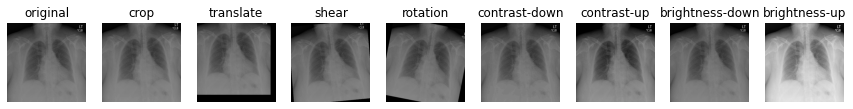

In [53]:
plot_augmented_samples(aug, 100)

## Normal vs abnormal tags

In [14]:
from collections import defaultdict

In [15]:
counter = defaultdict(lambda: 0)
for report in reports:
    tags = report['tags_manual']
    for tag in tags:
        counter[tag] += 1

In [23]:
len(reports)

3955

In [22]:
sorted(((k, v) for k, v in counter.items()), key=lambda x:x[1], reverse=True)

[('normal', 1391),
 ('Lung/hypoinflation', 245),
 ('Lung/hyperdistention', 164),
 ('Cardiomegaly', 157),
 ('Cardiomegaly/mild', 135),
 ('Aorta/tortuous', 126),
 ('Spine/degenerative', 115),
 ('Thoracic Vertebrae/degenerative', 114),
 ('Granulomatous Disease', 98),
 ('Atherosclerosis/aorta', 97),
 ('No Indexing', 95),
 ('Thoracic Vertebrae/degenerative/mild', 93),
 ('Technical Quality of Image Unsatisfactory ', 86),
 ('Calcinosis/aorta', 69),
 ('Markings/bronchovascular', 68),
 ('Aorta, Thoracic/tortuous', 59),
 ('Catheters, Indwelling/right', 54),
 ('Emphysema', 54),
 ('Pulmonary Congestion', 52),
 ('Pulmonary Atelectasis/base/left', 51),
 ('Pulmonary Disease, Chronic Obstructive', 50),
 ('Spondylosis/thoracic vertebrae', 49),
 ('Spine/degenerative/mild', 48),
 ('Cardiomegaly/borderline', 47),
 ('Opacity/lung/base/left', 46),
 ('Pulmonary Atelectasis/base/bilateral', 44),
 ('Lung/hyperdistention/mild', 40),
 ('Implanted Medical Device/left', 39),
 ('Diaphragm/right/elevated', 38),
 ('C

## Inspect sentences

### Split sentences

In [51]:
%run ../../utils/nlp.py

In [52]:
from collections import Counter, defaultdict

In [53]:
def split_sentences(report, end_token='.'):
    report = report.split()
    if report[-1] != end_token:
        report.append(end_token)

    sentences = []
    sentence = []
    for word in report:
        sentence.append(word)
        if word == end_token:
            sentences.append(sentence)
            sentence = []
            
    return [' '.join(s) for s in sentences]

In [54]:
reports_fname = os.path.join(REPORTS_DIR, 'reports.clean.v2.json')
with open(reports_fname, 'r') as f:
    reports_as_dict = json.load(f)
    reports = list(reports_as_dict.values())
len(reports_as_dict), len(reports)

(3826, 3826)

### Count sentences

In [55]:
sentence_counter = defaultdict(list)
for report in reports:
    for sentence in split_sentences(report['clean_text']):
        sentence_counter[sentence].append(report['filename'])
len(sentence_counter)

6448

In [56]:
l = list(sentence_counter.items())
l = sorted(l, key=lambda x: x[1], reverse=True)
l[:20]

[('cardiomediastinal silhouette demonstrates normal heart size with tortuosity and atherosclerosis of the thoracic aorta .',
  ['998.xml']),
 ('multilevel degenerative disc disease of the thoracic spine noted .',
  ['998.xml']),
 ('calcified mediastinal xxxx .', ['997.xml']),
 ('no pneumothorax , effusion , or pneumonia .', ['996.xml']),
 ('sternotomy sutures and bypass grafts have been placed in the interval .',
  ['995.xml']),
 ('both lungs remain clear and expanded with no infiltrates .', ['995.xml']),
 ('there are bilateral pulmonary nodules whose appearances suggest metastatic disease to lungs .',
  ['992.xml']),
 ('in the right lung , there is a NUMBER x NUMBER cm nodule overlying the posterior right\x01 NUMBER rib .',
  ['992.xml']),
 ('there is a NUMBER x NUMBER cm nodule xxxx above this in the interspace between the posterior\x01 NUMBER and\x01 NUMBER ribs on the right .',
  ['992.xml']),
 ('there is a NUMBER x NUMBER cm nodule projecting through the left\x01 NUMBER and\x01 NU

### Inspect broken sentences

In [57]:
import re

In [58]:
starts_with_number = re.compile('^\d')

In [59]:
[
    (s, filenames)
    for s, filenames in sentence_counter.items()
    if starts_with_number.search(s)
]

[('2 images .',
  ['1131.xml',
   '1234.xml',
   '1270.xml',
   '1382.xml',
   '1630.xml',
   '1766.xml',
   '1846.xml',
   '1963.xml',
   '2389.xml',
   '2584.xml',
   '2730.xml',
   '3130.xml',
   '3210.xml',
   '3795.xml',
   '539.xml',
   '64.xml',
   '680.xml',
   '741.xml',
   '81.xml']),
 ('4 images .', ['1525.xml']),
 ('3 images .', ['1643.xml', '3858.xml']),
 ('3 cm right upper lobe anterior segment mass .', ['2455.xml']),
 ('13 -\x01 NUMBER mm ring-shaped opacity with central lucency , seen with certainty on pa view only , projects over right midlung .',
  ['2750.xml']),
 ('2 views of the chest demonstrate sternotomy xxxx and mild thoracic dextroscoliosis .',
  ['3684.xml']),
 ('3 cm calcified right paratracheal lymph node .', ['61.xml'])]

In [60]:
reports_as_dict['1337.xml']['clean_text']

'low lung volumes . exam limited on lateral view by superimposed soft tissue and bony structures of the arm . lungs appear grossly clear . no evidence of pneumonia . heart and pulmonary xxxx appear normal . pleural spaces are clear . mediastinal contours appear normal . no acute cardiopulmonary disease on this exam .'

### Label sentences with chexpert labels

In [1]:
%run -n ../../eval_report_generation_chexpert_labeler.py

In [10]:
columns = ['sentences', 'appearances']
df_sentences = pd.DataFrame(list(sentence_counter.items()), columns=columns)
print(len(df_sentences))
df_sentences.head()

6448


,sentences,appearances
0,the cardiac silhouette and mediastinum size ar...,6
1,there is no pulmonary edema .,12
2,there is no focal consolidation .,34
3,there are no xxxx of a pleural effusion .,3
4,there is no evidence of pneumothorax .,23


In [11]:
%%time

labels = _apply_labeler_to_column(df_sentences, 'sentences',
                                  fill_empty=-2, fill_uncertain=-1)
labels.shape

Labelling sentences...
CPU times: user 61.7 ms, sys: 20.5 ms, total: 82.2 ms
Wall time: 9min 28s


(6448, 14)

In [13]:
df_sentences = _concat_df_matrix(df_sentences, labels)
print(len(df_sentences))
df_sentences.head()

6448


,sentences,appearances,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,the cardiac silhouette and mediastinum size ar...,6,1.0,0.0,0.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
1,there is no pulmonary edema .,12,1.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
2,there is no focal consolidation .,34,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
3,there are no xxxx of a pleural effusion .,3,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0
4,there is no evidence of pneumothorax .,23,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0,-2.0


In [17]:
fpath = os.path.join(REPORTS_DIR, 'sentences_with_chexpert_labels.csv')

In [18]:
df_sentences.to_csv(fpath, index=False)

### Load sentences

In [5]:
import pandas as pd

In [6]:
fpath = os.path.join(REPORTS_DIR, 'sentences_with_chexpert_labels.csv')

In [7]:
df_sentences = pd.read_csv(fpath)
df_sentences.head()

,sentences,appearances,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,the cardiac silhouette and mediastinum size ar...,6,1.0,0.0,0.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
1,there is no pulmonary edema .,12,1.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
2,there is no focal consolidation .,34,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
3,there are no xxxx of a pleural effusion .,3,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0
4,there is no evidence of pneumothorax .,23,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0,-2.0


### Count sentences' groups

#### Count normal vs abnormal

In [50]:
snt_normal = df_sentences[df_sentences['No Finding'] == 1]
snt_abnormal = df_sentences[df_sentences['No Finding'] == 0]
len(snt_normal), len(snt_abnormal)

(3306, 3142)

In [54]:
snt_normal['appearances'].sum()

13302

In [56]:
snt_abnormal['appearances'].sum()

4231

#### Number of abnormal sentences per report

In [65]:
is_sentence_normal = dict()
for index, row in df_sentences.iterrows():
    sentence = row['sentences']
    is_normal = row['No Finding']
    is_sentence_normal[sentence] = is_normal
len(is_sentence_normal)

6448

In [69]:
res = []
for report in reports:
    number_of_abnormal = sum(
        1 - is_sentence_normal[sentence]
        for sentence in split_sentences(report['clean_text'])
    )
    res.append(number_of_abnormal)
len(res)

3826

(array([1.502e+03, 1.176e+03, 6.420e+02, 3.320e+02, 0.000e+00, 1.220e+02,
        3.100e+01, 1.600e+01, 4.000e+00, 1.000e+00]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

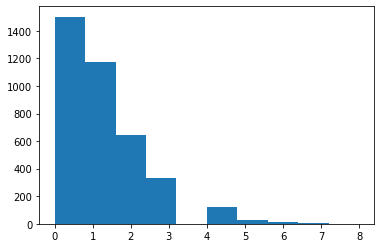

In [70]:
plt.hist(res)

#### Top-K most common sentences

In [40]:
cols = ['sentences', 'appearances']
df = df_sentences[cols].sort_values('appearances', ascending=False).head(5)
df

,sentences,appearances
38,the lungs are clear .,357
100,no pneumothorax .,263
20,lungs are clear .,234
19,heart size normal .,180
161,no pneumothorax or pleural effusion .,176


#### Plot sentences appearances distribution

In [24]:
len(df_sentences)

6448

In [20]:
df_sentences.sort_values('appearances', ascending=False).head()

,sentences,appearances,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
38,the lungs are clear .,357,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,no pneumothorax .,263,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,lungs are clear .,234,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,heart size normal .,180,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161,no pneumothorax or pleural effusion .,176,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
appearances = list(df_sentences['appearances'])

Text(0.5, 0, 'Number of appearances')

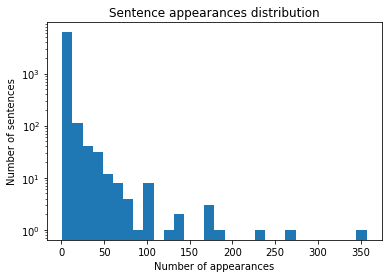

In [23]:
plt.hist(appearances, bins=30)
plt.yscale('log')

plt.title('Sentence appearances distribution')

plt.ylabel('Number of sentences')
plt.xlabel('Number of appearances')

<BarContainer object of 6448 artists>

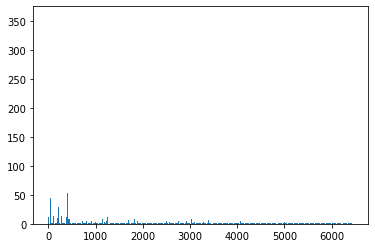

In [8]:
plt.bar(list(range(len(values))), values)

### Collect synonyms

In [35]:
import json
from collections import Counter, defaultdict

In [110]:
%run ../vocab/__init__.py

In [42]:
SYNONYMS = load_synonyms('iu_xray')
len(SYNONYMS)

{'the lungs are clear': ['lungs clear',
  'lungs are clear',
  'the lungs are clear bilaterally',
  'both lungs are clear and expanded',
  'clear lungs',
  'lungs are clear bilaterally',
  'the lungs appear clear'],
 'heart size normal': ['the heart size is normal',
  'heart size is normal',
  'the heart is normal in size',
  'heart size within normal limits',
  'normal heart size',
  'heart size is within normal limits',
  'normal heart',
  'heart size is now normal',
  'the heart is of normal size',
  'the heart is normal in size and contour',
  'the heart size is within normal limits',
  'the heart is normal size'],
 'no pneumothorax or pleural effusion': ['no pleural effusion or pneumothorax',
  'there is no pleural effusion or pneumothorax',
  'no pleural effusion or pneumothorax is seen',
  'no pleural effusions or pneumothoraces',
  'there is no pneumothorax or pleural effusion',
  'there is no pneumothorax or large pleural effusion',
  'there is no effusion or pneumothorax',
  

In [74]:
SYNONYMS = {}

In [75]:
FOR_LATER = set()

In [76]:
SEEN_SENTENCES = set()
for representative, syns in SYNONYMS.items():
    SEEN_SENTENCES.add(representative)
    for s in syns:
        SEEN_SENTENCES.add(s)
len(SEEN_SENTENCES)

0

In [77]:
def is_number(s):
    try:
        s = int(s)
        return True
    except:
        return False

In [101]:
def process_sentences(sentences, skip_later=True):
    index_to_repr = {
        index: representative
        for index, representative in enumerate(SYNONYMS.keys())
    }
    
    def _print_reprs():
        print('-'*20)
        for index, representative in index_to_repr.items():
            print(f'{index} - {representative}')
    
    def _add_new(sentence):
        index_to_repr[len(SYNONYMS)] = sentence
        SYNONYMS[sentence] = []
        SEEN_SENTENCES.add(sentence)

    def _add_as_syn(sentence, option):
        option = int(option)
            
        if option not in index_to_repr:
            print(f'No synonym found for option={option}')
            raise
        representative = index_to_repr[option]

        if representative not in SYNONYMS:
            print(f'representative {representative} not in SYNS')
            # Internal error!
            raise

        SYNONYMS[representative].append(sentence)
        SEEN_SENTENCES.add(sentence)
        
    _print_reprs()
    
    sentence_idx = 0
    while sentence_idx < len(sentences):
        sentence = sentences[sentence_idx]
        sentence = clean_sentence(sentence)
        
        if sentence in SEEN_SENTENCES or (not skip_later and sentence in FOR_LATER):
            sentence_idx += 1
            continue
            
        option = input(f'"{sentence}" --> ')
        
        if is_number(option):
            _add_as_syn(sentence, option)
            sentence_idx += 1
        elif option == 'l': # later
            FOR_LATER.add(sentence)
            sentence_idx += 1
        elif ',' in option: # split and allocate
            added_new = False
            for suboption in option.split(','):
                suboption = suboption.strip()
                if suboption == 'n':
                    new_sentence = input('\t\tInput new sentence: ')
                    _add_new(new_sentence)
                    added_new = True
                else:
                    _add_as_syn(sentence, suboption)

            if added_new:
                _print_reprs()
                
            sentence_idx += 1
        elif option == 'n': # new
            _add_new(sentence)
            _print_reprs()
            sentence_idx += 1
        elif option == 'b':
            print('Breaking')
            break
        else:
            print(f'Option not recognized: {option}')

In [106]:
some_sentences = df_sentences.groupby('Fracture')['sentences'].apply(list)
some_sentences = sorted(some_sentences[0], key=lambda x: len(x))
process_sentences(some_sentences)

--------------------
0 - heart size normal
1 - no small heart size
2 - heart size top normal
3 - normal cardiac contour
4 - no heart size is normal
5 - the heart is not enlarged
6 - heart size normal in lv contour
7 - heart size and shape are normal
8 - heart size slightly upper normal
9 - the heart is not grossly enlarged
10 - no pneumonia
11 - no lobar pneumonia
12 - no effusion
13 - no large effusions
14 - no edema
15 - no overt edema
16 - no laryngeal edema
17 - no significant pulmonary edema
18 - no consolidation
19 - no pneumothorax
20 - there is no large pneumothorax
21 - no pleural line of pneumothorax
"no fracture" --> n
--------------------
0 - heart size normal
1 - no small heart size
2 - heart size top normal
3 - normal cardiac contour
4 - no heart size is normal
5 - the heart is not enlarged
6 - heart size normal in lv contour
7 - heart size and shape are normal
8 - heart size slightly upper normal
9 - the heart is not grossly enlarged
10 - no pneumonia
11 - no lobar pneum

In [111]:
save_synonyms('iu_xray', SYNONYMS)

### Max amounts

#### Max amount of words in a sentence

In [76]:
sorted([(len(s.split()), s) for s in sentence_counter], reverse=True)

[(47,
  'in the left superior lower lobe there is a 1.9 x 1.8 cm round area of density which has increased in size compared to prior chest radiograph and recommend a xxxx chest , abdomen and pelvis with contrast as this area is suspicious for potential malignancy .'),
 (45,
  'there are multiple overlying leads at the level of the left lower chest , with overlying xxxx xxxx or clothing there is this is thought to account for mild increased density the left lung base on ap view , with correlate on lateral view .'),
 (38,
  'there are xxxx xxxx pulmonary opacities with blunting of the bilateral costophrenic xxxx , on the right greater than left , with pleural thickening versus loculated pleural fluid along the peripheral aspect of the right upper lobe .'),
 (36,
  'there are acute mild anterior xxxx deformities identified at l1-l2. there is retropulsion of the posterior vertebral body of l1. a ct of the lumbar spine was already ordered at the time of this dictation .'),
 (35,
  'the infr

In [82]:
47

47

#### Max amount of words

In [83]:
max(len(report['clean_text'].split()) for report in reports)

186

#### Max amount of sentences

In [86]:
max(len(split_sentences(report['clean_text'])) for report in reports)

18

## Apply chexpert labeler

In [ ]:
%run -n ../../eval_report_generation_chexpert_labeler.py

In [51]:
fname = os.path.join(REPORTS_DIR, 'reports.clean.json')
with open(fname, 'r') as f:
    clean_reports = list(json.load(f).values())
len(clean_reports)

3826

In [52]:
reports_by_filename = {
    r['filename']: r['clean_text']
    for r in clean_reports
}
len(reports_by_filename)

In [ ]:
df_reports = pd.DataFrame(reports_by_filename, columns=['reports'])
print(len(df_reports))
df_reports.head()

In [ ]:
%%time

labels = _apply_labeler_to_column(df_reports, 'reports',
                                  fill_empty=-2, fill_uncertain=-1)
labels.shape

In [ ]:
df_reports = _concat_df_matrix(df_reports, labels)
df_reports.head()

## Apply MIRQI labeler

In [111]:
from collections import defaultdict

In [36]:
%run -n ../../eval_report_generation_mirqi.py

In [40]:
path = os.path.join(REPORTS_DIR, 'reports_with_chexpert_labels.csv')
df = pd.read_csv(path, index_col=0)
df = df[['Reports', 'filename']]
df.head()

,Reports,filename
0,the cardiac silhouette and mediastinum size ar...,1.xml
1,the cardiomediastinal silhouette is within nor...,10.xml
2,both lungs are clear and expanded . heart and ...,100.xml
3,there is xxxx increased opacity within the rig...,1000.xml
4,interstitial markings are diffusely prominent ...,1001.xml


In [98]:
%%time

mirqi_df = _apply_mirqi_to_df(df, gt_col_name='Reports', gen_col_name='Reports')
mirqi_df.head()

Evaluating reports with MIRQI...
	Calling ~/software/miniconda3/envs/chexpert-label/bin/python evaluate.py --reports_path_gt /mnt/workspace/medical-ai/tmp/mirqi/gt-input.csv --reports_path_cand /mnt/workspace/medical-ai/tmp/mirqi/gen-input.csv --output_path /mnt/workspace/medical-ai/tmp/mirqi/output.csv 
CPU times: user 159 ms, sys: 12.4 ms, total: 172 ms
Wall time: 31min 47s


,Reports,filename,attributes-gt,attributes-gen,MIRQI-r,MIRQI-p,MIRQI-f
0,the cardiac silhouette and mediastinum size ar...,1.xml,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,1.0,1.0,1.0
1,the cardiomediastinal silhouette is within nor...,10.xml,(contour|Enlarged Cardiomediastinum|NEGATIVE|)...,(contour|Enlarged Cardiomediastinum|NEGATIVE|)...,1.0,1.0,1.0
2,both lungs are clear and expanded . heart and ...,100.xml,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,1.0,1.0,1.0
3,there is xxxx increased opacity within the rig...,1000.xml,(mass|Lung Lesion|UNCERTAIN|possible) (consoli...,(mass|Lung Lesion|UNCERTAIN|possible) (consoli...,1.0,1.0,1.0
4,interstitial markings are diffusely prominent ...,1001.xml,(interstitial markings|Other Finding|POSITIVE|...,(interstitial markings|Other Finding|POSITIVE|...,1.0,1.0,1.0


In [112]:
valoration_to_int = {
    'POSITIVE': 1,
    'NEGATIVE': 0,
    'UNCERTAIN': -1,
}

WRONG_LEN_ATTRIBUTES = defaultdict(list)

def expand_attributes(row):
    attributes = row['attributes-gt']
    attributes = [s.strip('()') for s in attributes.split(') (')]
    attributes = [s.split('|') for s in attributes]
    
    for tup in attributes:
        if len(tup) != 4:
            WRONG_LEN_ATTRIBUTES['len-not-4'].append(tup)
            continue
        text, label, value, additional = tup
        row[label] = valoration_to_int[value]
        
    return row

In [113]:
mirqi_df = mirqi_df.apply(expand_attributes, axis=1)
mirqi_df.head()

,Airspace Disease,Airspace Opacity,Atelectasis,Calcinosis,Cardiomegaly,Consolidation,Edema,Emphysema,Enlarged Cardiomediastinum,Fracture,...,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Reports,Scoliosis,Support Devices,attributes-gen,attributes-gt,filename
0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,...,0.0,NaN,NaN,0.0,the cardiac silhouette and mediastinum size ar...,NaN,NaN,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,1.xml
1,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN,...,0.0,NaN,NaN,0.0,the cardiomediastinal silhouette is within nor...,NaN,NaN,(contour|Enlarged Cardiomediastinum|NEGATIVE|)...,(contour|Enlarged Cardiomediastinum|NEGATIVE|)...,10.xml
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,both lungs are clear and expanded . heart and ...,NaN,NaN,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,100.xml
3,-1.0,-1.0,-1.0,NaN,0.0,-1.0,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0.0,there is xxxx increased opacity within the rig...,NaN,NaN,(mass|Lung Lesion|UNCERTAIN|possible) (consoli...,(mass|Lung Lesion|UNCERTAIN|possible) (consoli...,1000.xml
4,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,interstitial markings are diffusely prominent ...,NaN,NaN,(interstitial markings|Other Finding|POSITIVE|...,(interstitial markings|Other Finding|POSITIVE|...,1001.xml


In [117]:
base_cols = ['filename', 'Reports', 'attributes-gt', 'attributes-gen', 'MIRQI-r', 'MIRQI-p', 'MIRQI-f']
columns = base_cols + [c for c in mirqi_df if c not in base_cols]
mirqi_df = mirqi_df[columns]
mirqi_df.head()

,filename,Reports,attributes-gt,attributes-gen,MIRQI-r,MIRQI-p,MIRQI-f,Airspace Disease,Airspace Opacity,Atelectasis,...,Hernia,Hypoinflation,Lung Lesion,Other Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Scoliosis,Support Devices
0,1.xml,the cardiac silhouette and mediastinum size ar...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,1.0,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
1,10.xml,the cardiomediastinal silhouette is within nor...,(contour|Enlarged Cardiomediastinum|NEGATIVE|)...,(contour|Enlarged Cardiomediastinum|NEGATIVE|)...,1.0,1.0,1.0,0.0,0.0,NaN,...,NaN,NaN,NaN,1.0,0.0,NaN,NaN,0.0,NaN,NaN
2,100.xml,both lungs are clear and expanded . heart and ...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,1.0,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000.xml,there is xxxx increased opacity within the rig...,(mass|Lung Lesion|UNCERTAIN|possible) (consoli...,(mass|Lung Lesion|UNCERTAIN|possible) (consoli...,1.0,1.0,1.0,-1.0,-1.0,-1.0,...,NaN,NaN,-1.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN
4,1001.xml,interstitial markings are diffusely prominent ...,(interstitial markings|Other Finding|POSITIVE|...,(interstitial markings|Other Finding|POSITIVE|...,1.0,1.0,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
mirqi_df.replace(np.nan, -2, inplace=True)
mirqi_df.head()

,filename,Reports,attributes-gt,attributes-gen,MIRQI-r,MIRQI-p,MIRQI-f,Airspace Disease,Airspace Opacity,Atelectasis,...,Hernia,Hypoinflation,Lung Lesion,Other Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Scoliosis,Support Devices
0,1.xml,the cardiac silhouette and mediastinum size ar...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,1.0,1.0,1.0,-2.0,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,0.0,-2.0,-2.0
1,10.xml,the cardiomediastinal silhouette is within nor...,(contour|Enlarged Cardiomediastinum|NEGATIVE|)...,(contour|Enlarged Cardiomediastinum|NEGATIVE|)...,1.0,1.0,1.0,0.0,0.0,-2.0,...,-2.0,-2.0,-2.0,1.0,0.0,-2.0,-2.0,0.0,-2.0,-2.0
2,100.xml,both lungs are clear and expanded . heart and ...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,1.0,1.0,1.0,-2.0,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
3,1000.xml,there is xxxx increased opacity within the rig...,(mass|Lung Lesion|UNCERTAIN|possible) (consoli...,(mass|Lung Lesion|UNCERTAIN|possible) (consoli...,1.0,1.0,1.0,-1.0,-1.0,-1.0,...,-2.0,-2.0,-1.0,-2.0,0.0,-2.0,-2.0,0.0,-2.0,-2.0
4,1001.xml,interstitial markings are diffusely prominent ...,(interstitial markings|Other Finding|POSITIVE|...,(interstitial markings|Other Finding|POSITIVE|...,1.0,1.0,1.0,-2.0,1.0,-2.0,...,-2.0,-2.0,-2.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0


In [119]:
path = os.path.join(REPORTS_DIR, 'reports_with_mirqi_labels.csv')
mirqi_df.to_csv(path)

### Load mirqi_df

In [ ]:
path = os.path.join(REPORTS_DIR, 'reports_with_mirqi_labels.csv')
mirqi_df = pd.read_csv(path)

### Values without perfect scores

i.e. MIRQI's match procedure is incorrect

In [73]:
wrong_values = mirqi_df.loc[(mirqi_df['MIRQI-r'] < 0.9) | (mirqi_df['MIRQI-p'] < 0.9) | (mirqi_df['MIRQI-f'] < 0.9)]
len(wrong_values)

300

In [74]:
wrong_values.head()

,Reports,filename,attributes-gt,attributes-gen,MIRQI-r,MIRQI-p,MIRQI-f
23,the heart size and mediastinal contours appear...,1019.xml,(contour|Enlarged Cardiomediastinum|NEGATIVE|m...,(contour|Enlarged Cardiomediastinum|NEGATIVE|m...,0.880597,0.900000,0.890193
35,the lungs are clear without evidence of focal ...,103.xml,(airspace disease|Airspace Opacity|NEGATIVE|fo...,(airspace disease|Airspace Opacity|NEGATIVE|fo...,0.971428,0.703703,0.816172
41,right xxxx-a-xxxx is in xxxx . the heart size ...,1035.xml,(the heart|Cardiomegaly|POSITIVE|size) (heart ...,(the heart|Cardiomegaly|POSITIVE|size) (heart ...,0.876923,0.933333,0.904249
51,the heart size and pulmonary vascularity appea...,1044.xml,(the heart|Cardiomegaly|POSITIVE|size) (heart ...,(the heart|Cardiomegaly|POSITIVE|size) (heart ...,0.703703,0.949999,0.808510
52,"heart size within normal limits , stable media...",1045.xml,(contour|Enlarged Cardiomediastinum|NEGATIVE|s...,(contour|Enlarged Cardiomediastinum|NEGATIVE|s...,0.966666,0.600000,0.740425


## Get sample reports

For LATINX in AI workshop

In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from pycocoevalcap.bleu import bleu_scorer
from pycocoevalcap.rouge import rouge

In [3]:
%run ../common.py
%run ../iu_xray.py
%run ../../utils/nlp.py
%run ../../utils/__init__.py

In [39]:
CONSTANT_REPORT = """the heart is normal in size . the mediastinum is unremarkable . 
the lungs are clear .
there is no pneumothorax or pleural effusion . no focal airspace disease .
no pleural effusion or pneumothorax ."""

In [40]:
dataset = IUXRayDataset(dataset_type='all')
report_reader = ReportReader(dataset.get_vocab())
len(dataset)

7426

the cardiac silhouette is mildly enlarged . a lobulated opacity is identified superior to the heart , in the anterior mediastinum on the lateral view , possibly consistent with a tortuous / ectatic thoracic aorta versus an anterior mediastinal mass . the thoracic aorta is tortuous and calcified . no focal areas of pulmonary consolidation . the lungs are hyperexpanded with flattening of the bilateral hemidiaphragms . no pneumothorax or pleural effusion . severe degenerative changes of the thoracic spine .


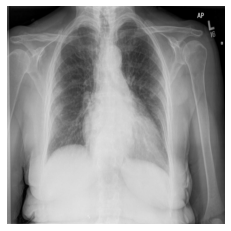

In [52]:
idx = GT_IDX
item = dataset[idx]
image = arr_to_range(item.image.permute(1, 2, 0))
report_base = report_reader.idx_to_text(item.report)
plt.imshow(image)
plt.axis('off')
print(report_base)

In [50]:
GT_IDX = 7289

In [41]:
target = [
    'the cardiac silhouette is enlarged',
    # 'the lungs are hyper',
    # 'the heart is',
]
not_target = [
    # 'the lungs are clear',
#     'the mediastinum is unremarkable',
#     'the mediastinum is stable',
#     'the mediastinum is normal',
#     'the mediastinum is within normal limits',
]
found = []
found_names = set()
for idx, report in enumerate(dataset.reports):
    filename = report['filename']
    report = report_reader.idx_to_text(report['tokens_idxs'])
    if all(t in report for t in target) and all(t not in report for t in not_target):
        if filename not in found_names:
            found.append((idx, report))
        found_names.add(filename)
len(found)

6

In [49]:
found[5]

(7354,
 'the cardiac silhouette is enlarged with no comparison studies . findings are xxxx accentuated by low lung volumes and eventration of the anterior right hemidiaphragm , however , cardiomegaly or less xxxx , pericardial effusion is suspected . the lungs are hypoinflated with central bronchovascular crowding but no evidence of overt pulmonary edema . the lungs are grossly clear of focal airspace disease , pneumothorax , pleural effusion . there are no acute bony findings . there are degenerative changes of the thoracic spine . patient appears morbidly obese .')

In [143]:
gen = 'the heart is enlarged. the mediastinum is unremarkable . the lungs are hyperinflated with mildly coarsened interstitial markings . '
# the lungs are hyperexpanded
# the lungs are hyperinflated with mildly coarsened interstitial markings
# the lungs are hyperinflated with biapical pleural-parenchymal scarring and upward retraction of the xxxx

In [23]:
def measure_bleu_rouge(gen, gt):
    scorer = bleu_scorer.BleuScorer(n=4)
    scorer += (gen, [gt])
    bleu_1_4, _ = scorer.compute_score()
    
    scorer = rouge.Rouge()
    rouge_score = scorer.calc_score([gen], [gt])
    
    print('BLEU 1-4: ', bleu_1_4)
    print('BLEU: ', np.mean(bleu_1_4))
    print('ROUGE-L: ', rouge_score)

In [10]:
report_1 = """the heart is normal in size . the mediastinum is unremarkable . 
the lungs are clear ."""
report_2 = """the heart is normal . the mediastinum is otherwise unremarkable . 
lungs are both clear ."""
measure_bleu_rouge(report_1, report_2)

BLEU 1-4:  [0.823529411716263, 0.6806139096884855, 0.498031475650019, 0.36447528422896314]
BLEU:  0.5916625203209327
ROUGE:  0.7922077922077921


In [86]:
report = report_reader.idx_to_text(dataset[GT_IDX].report)
report

'the cardiac silhouette is mildly enlarged . a lobulated opacity is identified superior to the heart , in the anterior mediastinum on the lateral view , possibly consistent with a tortuous / ectatic thoracic aorta versus an anterior mediastinal mass . the thoracic aorta is tortuous and calcified . no focal areas of pulmonary consolidation . the lungs are hyperexpanded with flattening of the bilateral hemidiaphragms . no pneumothorax or pleural effusion . severe degenerative changes of the thoracic spine .'

In [63]:
gt = """the cardiac silhouette is enlarged .
the lungs are hyperexpanded with flattening of the bilateral hemidiaphragms .
no pneumothorax or pleural effusion ."""
# the lungs are hyperinflated with mildly coarsened interstitial markings .
# with flattening of the bilateral hemidiaphragms 

In [64]:
gen = """the cardiac silhouette is normal in size .
the lungs are clear .
no pneumothorax or pleural effusion ."""

In [65]:
measure_bleu_rouge(gen, gt)

BLEU 1-4:  [0.6395982117214318, 0.58775019547367, 0.5291550092647807, 0.4606142784620598]
BLEU:  0.5542794237304856
ROUGE-L:  0.6714648602878917


In [77]:
gt = "the cardiac silhouette is enlarged . the lungs are hyperexpanded with flattening of the bilateral hemidiaphragms . no pneumothorax or pleural effusion ."
gen = "the cardiac silhouette is normal in size and configuration . the lungs are clear . no pneumothorax or pleural effusion ."
measure_bleu_rouge(gen, gt)

BLEU 1-4:  [0.6493974591358048, 0.5951826025196549, 0.5343297171373826, 0.46369919062449266]
BLEU:  0.5606522423543338
ROUGE-L:  0.6762749445676276


In [13]:
measure_bleu_rouge(gen, gt)

BLEU 1-4:  [0.6493974591358048, 0.5951826025196549, 0.5343297171373826, 0.46369919062449266]
BLEU:  0.5606522423543338
ROUGE:  0.644191714053615


## Check no-findings vs labels==0

In [5]:
from collections import defaultdict

In [6]:
chexpert_path = os.path.join(REPORTS_DIR, 'reports_with_chexpert_labels.csv')
mirqi_path = os.path.join(REPORTS_DIR, 'reports_with_mirqi_labels.csv')

In [7]:
chexpert_df = pd.read_csv(chexpert_path, index_col=0)
chexpert_df.replace(-1, 1, inplace=True)
chexpert_df.replace(-2, 0, inplace=True)
chexpert_df.head()

,Reports,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,filename
0,the cardiac silhouette and mediastinum size ar...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.xml
1,the cardiomediastinal silhouette is within nor...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.xml
2,both lungs are clear and expanded . heart and ...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.xml
3,there is xxxx increased opacity within the rig...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1000.xml
4,interstitial markings are diffusely prominent ...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1001.xml


In [13]:
mirqi_df = pd.read_csv(mirqi_path, index_col=0)
mirqi_df.drop(columns=['attributes-gen', 'MIRQI-r', 'MIRQI-p', 'MIRQI-f'], inplace=True)
mirqi_df.rename(columns={'attributes-gt': 'attributes'}, inplace=True)
mirqi_df.replace(-1, 1, inplace=True)
mirqi_df.replace(-2, 0, inplace=True)
mirqi_df.head()

,filename,Reports,attributes,Airspace Disease,Airspace Opacity,Atelectasis,Calcinosis,Cardiomegaly,Consolidation,Edema,...,Hernia,Hypoinflation,Lung Lesion,Other Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Scoliosis,Support Devices
0,1.xml,the cardiac silhouette and mediastinum size ar...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.xml,the cardiomediastinal silhouette is within nor...,(contour|Enlarged Cardiomediastinum|NEGATIVE|)...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100.xml,both lungs are clear and expanded . heart and ...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1000.xml,there is xxxx increased opacity within the rig...,(mass|Lung Lesion|UNCERTAIN|possible) (consoli...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1001.xml,interstitial markings are diffusely prominent ...,(interstitial markings|Other Finding|POSITIVE|...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
base_columns = set(['filename', 'Reports', 'attributes'])
MIRQI_LABELS = [c for c in mirqi_df.columns if c not in base_columns]

In [14]:
len(chexpert_df), len(mirqi_df)

(3826, 3826)

In [16]:
df = chexpert_df.merge(mirqi_df, on='filename', suffixes=['_chx', '_mirqi'])
print(len(df))
df.head()

3826


,Reports_chx,No Finding,Enlarged Cardiomediastinum_chx,Cardiomegaly_chx,Lung Lesion_chx,Lung Opacity,Edema_chx,Consolidation_chx,Pneumonia_chx,Atelectasis_chx,...,Hernia,Hypoinflation,Lung Lesion_mirqi,Other Finding,Pleural Effusion_mirqi,Pleural Other_mirqi,Pneumonia_mirqi,Pneumothorax_mirqi,Scoliosis,Support Devices_mirqi
0,the cardiac silhouette and mediastinum size ar...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,the cardiomediastinal silhouette is within nor...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,both lungs are clear and expanded . heart and ...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,there is xxxx increased opacity within the rig...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,interstitial markings are diffusely prominent ...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
reports_by_condition = defaultdict(set)

for index, row in chexpert_df.iterrows():
    filename = row['filename']
    report = row['Reports']
    labels = row[CHEXPERT_LABELS]

    tup = (index, filename, report)

    no_findings = labels['No Finding']
    
    if no_findings == 1:
        reports_by_condition['no-findings-1'].add(tup)
        if any(l != 0 for l in labels[1:-1]):
            # Exclude no-findings and support-devices
            reports_by_condition['inconsistent'].add(tup)
    else:
        if not any(l != 0 for l in labels[1:-1]):
            reports_by_condition['no-findings-absent'].add(tup)
    
    if all(l != 1 for l in labels):
        reports_by_condition['no-1s'].add(tup)
    
[(k, len(v)) for k, v in reports_by_condition.items()]

[('no-findings-1', 1502), ('no-findings-absent', 675), ('no-1s', 644)]

In [19]:
l = list(reports_by_condition['no-findings-absent'])
l[:5]

[(1654,
  '256.xml',
  'postoperative changes are present in the left fifth rib . residual radiopaque sutures are also present in the left upper lobe . the lungs are clear with no infiltrates or masses . heart and mediastinum are normal .'),
 (987,
  '1930.xml',
  'the cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size . the lungs are mildly hypoinflated but grossly clear of focal airspace disease , pneumothorax , or pleural effusion . there are mild degenerative endplate changes in the thoracic spine . there are no acute bony findings .'),
 (3373,
  '575.xml',
  'the heart size and mediastinal silhouette are within normal limits for contour . the lungs are clear . no pneumothorax or pleural effusions . the xxxx are intact . stable calcified granuloma in the left lung .'),
 (200,
  '1189.xml',
  'normal heart size and hilar vascular markings . evidence of prior granulomatous disease . the lungs are clear without focal area of consolidation , pleural

In [24]:
mirqi_df.loc[mirqi_df['filename'] == '256.xml'][MIRQI_LABELS]

,Airspace Disease,Airspace Opacity,Atelectasis,Calcinosis,Cardiomegaly,Consolidation,Edema,Emphysema,Enlarged Cardiomediastinum,Fracture,Hernia,Hypoinflation,Lung Lesion,Other Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Scoliosis,Support Devices
1654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
l = list(reports_by_condition['no-1s'])
l[:10]

[('1652.xml',
  'dextroscoliosis of the thoracic spine . clear lungs bilaterally . no pneumothorax or pleural effusion . no acute bony abnormalities .'),
 ('2479.xml',
  'there is a right-sided chest xxxx identified whose distal tip projects over the svc . heart size is normal . low lung volumes with elevated right hemidiaphragm . the lungs are grossly clear . no focal infiltrate . no pleural effusion or pneumothorax . normal pulmonary vascularity . normal mediastinal and hilar contours . degenerative changes of the spine .'),
 ('398.xml',
  'no focal consolidation , pneumothorax or definite pleural effusion . heart size and pulmonary vascularity within normal limits , no mediastinal widening characteristic in appearance of vascular injury . right paratracheal calcifications suggest a previous granulomatous process . no acute osseous injury xxxx demonstrated .'),
 ('1268.xml',
  'the cardiomediastinal silhouette is normal size and configuration . the thoracic aorta is tortuous . pulmon

In [25]:
l = list(reports_by_condition['no-findings-1'])
l[:10]

[('176.xml',
  'cardiac and mediastinal contours are within normal limits . the lungs are clear . bony structures are intact .'),
 ('1915.xml',
  'both lungs are clear and expanded . heart and mediastinum normal .'),
 ('270.xml',
  'the cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size . the lungs are clear of focal airspace disease , pneumothorax , or pleural effusion . there are no acute bony findings .'),
 ('1078.xml',
  'the lungs are clear . there is no pleural effusion or pneumothorax . the heart and mediastinum are normal . the skeletal structures are normal .'),
 ('1323.xml',
  'the heart size and mediastinal silhouette are within normal limits for contour . the lungs are clear . no pneumothorax or pleural effusions . the xxxx are intact .'),
 ('2291.xml',
  'heart size is normal . the lungs are clear . there are no focal air space consolidations . no pleural effusions or pneumothoraces . the hilar and mediastinal contours are normal . norm